<a href="https://colab.research.google.com/github/MAHMUDURRAHMANARNOB/HIT140_assessment2/blob/main/Investigation_A_Revisiting_with_marged_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Code Cell: Setup and Data Loading**

In [11]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
%matplotlib inline

In [13]:
# Load merged dataset
merged_df = pd.read_csv('merged_dataset.csv')


In [15]:
# Basic cleaning (ensure consistency)
merged_df['habit'] = merged_df['habit'].fillna('unknown')
merged_df['bat_landing_to_food'] = np.clip(merged_df['bat_landing_to_food'], 0, merged_df['bat_landing_to_food'].quantile(0.95))
merged_df['rat_arrival_number'] = merged_df['rat_arrival_number'].fillna(0).astype(int)

print("Merged dataset loaded. Shape:", merged_df.shape)
print(merged_df.head())

Merged dataset loaded. Shape: (925, 31)
         start_time  bat_landing_to_food habit  rat_period_start  \
0  30/12/2017 18:37            16.000000   rat  30/12/2017 18:35   
1  30/12/2017 19:51             0.074016  fast  30/12/2017 19:50   
2  30/12/2017 19:51             4.000000  fast  30/12/2017 19:50   
3  30/12/2017 19:52            10.000000   rat  30/12/2017 19:50   
4  30/12/2017 19:54            15.000000   rat  30/12/2017 19:50   

     rat_period_end  seconds_after_rat_arrival  risk  reward  month  \
0  30/12/2017 18:38                        108     1       0      0   
1  30/12/2017 19:55                         17     0       1      0   
2  30/12/2017 19:55                         41     0       1      0   
3  30/12/2017 19:55                        111     1       0      0   
4  30/12/2017 19:55                        194     1       0      0   

        sunset_time  ...  sec_mismatch  time bat_landing_number  \
0  30/12/2017 16:45  ...          12.0   NaN             

**Code Cell: Descriptive Stats and T-tests**

In [17]:
# Group by rat_presence for means and std
desc_stats = merged_df.groupby('rat_arrival_number')[['bat_landing_to_food', 'risk', 'reward']].agg(['mean', 'std'])
print("Descriptive Stats by Rat Presence:\n", desc_stats)


Descriptive Stats by Rat Presence:
                    bat_landing_to_food                 risk           \
                                  mean        std      mean      std   
rat_arrival_number                                                     
0                             8.613408  11.195278  0.501632  0.50027   
1                             0.063772   0.000000  1.000000  0.00000   
2                             0.063772   0.000000  1.000000  0.00000   
3                             0.063772        NaN  1.000000      NaN   
4                             0.063772        NaN  1.000000      NaN   

                      reward            
                        mean       std  
rat_arrival_number                      
0                   0.526659  0.499561  
1                   0.000000  0.000000  
2                   0.000000  0.000000  
3                   0.000000       NaN  
4                   0.000000       NaN  


In [22]:
# T-test: Vigilance by rat presence
vigilance_rat = merged_df[merged_df['rat_arrival_number'] == 1]['bat_landing_to_food']
vigilance_no_rat = merged_df[merged_df['rat_arrival_number'] == 0]['bat_landing_to_food']
t_stat, p_val = stats.ttest_ind(vigilance_rat, vigilance_no_rat, nan_policy='omit')
print(f"T-test for Vigilance by Rat Presence: t-stat={t_stat:.2f}, p-value={p_val:.4f}")



T-test for Vigilance by Rat Presence: t-stat=-1.08, p-value=0.2807


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [23]:
# T-test: Reward by rat presence
reward_rat = merged_df[merged_df['rat_arrival_number'] == 1]['reward']
reward_no_rat = merged_df[merged_df['rat_arrival_number'] == 0]['reward']
t_stat_reward, p_val_reward = stats.ttest_ind(reward_rat, reward_no_rat, nan_policy='omit')
print(f"T-test for Reward by Rat Presence: t-stat={t_stat_reward:.2f}, p-value={p_val_reward:.4f}")


T-test for Reward by Rat Presence: t-stat=-1.49, p-value=0.1365


**Code Cell: OLS Regression**

In [24]:
# OLS Regression: bat_landing_to_food ~ risk + rat_arrival_number + interaction
merged_df['interaction'] = merged_df['risk'] * merged_df['rat_arrival_number']
X = sm.add_constant(merged_df[['risk', 'rat_arrival_number', 'interaction']])
y = merged_df['bat_landing_to_food']
reg_model = sm.OLS(y, X, missing='drop').fit()
print(reg_model.summary())


                             OLS Regression Results                            
Dep. Variable:     bat_landing_to_food   R-squared:                       0.082
Model:                             OLS   Adj. R-squared:                  0.080
Method:                  Least Squares   F-statistic:                     41.14
Date:                 Thu, 16 Oct 2025   Prob (F-statistic):           7.68e-18
Time:                         02:42:00   Log-Likelihood:                -3505.5
No. Observations:                  925   AIC:                             7017.
Df Residuals:                      922   BIC:                             7032.
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  5.4

**Code Cell: Logistic Regression for Risk Prediction**

In [25]:
# Logistic Regression: Predict risk
features = merged_df[['bat_landing_to_food', 'reward', 'hours_after_sunset']]
target = merged_df['risk']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print(f"Accuracy of Risk Classifier: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", cm)
print("Feature Coefficients:", clf.coef_)


Accuracy of Risk Classifier: 83.81%
Confusion Matrix:
 [[119  27]
 [ 18 114]]
Feature Coefficients: [[ 7.91175541e-02 -3.08472499e+00 -4.99519920e-04]]


**Code Cell: Visualisations**

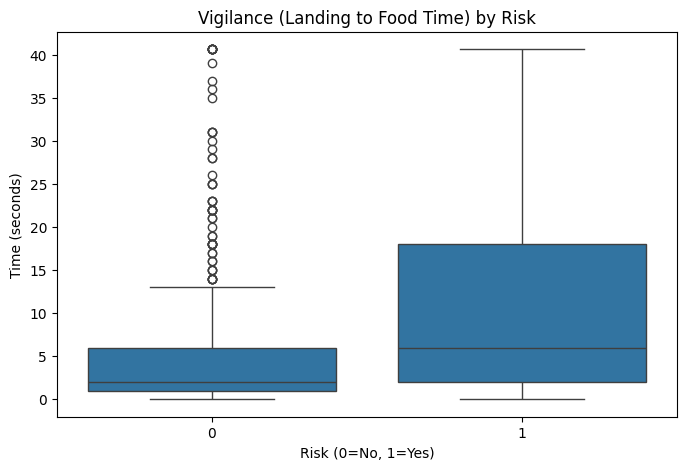

In [26]:
# Boxplot: Vigilance by Risk
plt.figure(figsize=(8, 5))
sns.boxplot(x='risk', y='bat_landing_to_food', data=merged_df)
plt.title('Vigilance (Landing to Food Time) by Risk')
plt.xlabel('Risk (0=No, 1=Yes)')
plt.ylabel('Time (seconds)')
plt.show()


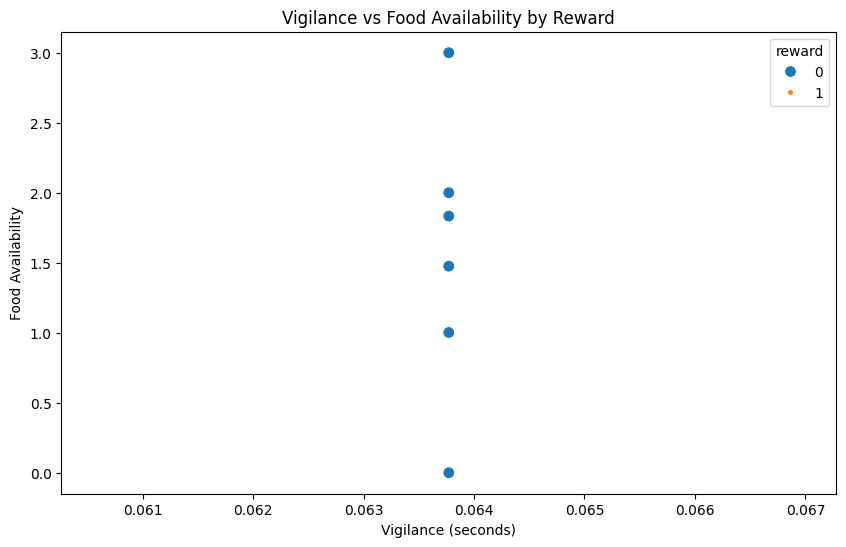

In [27]:
# Scatter: Vigilance vs Food Availability, colored by Reward
plt.figure(figsize=(10, 6))
sns.scatterplot(x='bat_landing_to_food', y='food_availability', hue='reward', size='reward', data=merged_df)
plt.title('Vigilance vs Food Availability by Reward')
plt.xlabel('Vigilance (seconds)')
plt.ylabel('Food Availability')
plt.show()

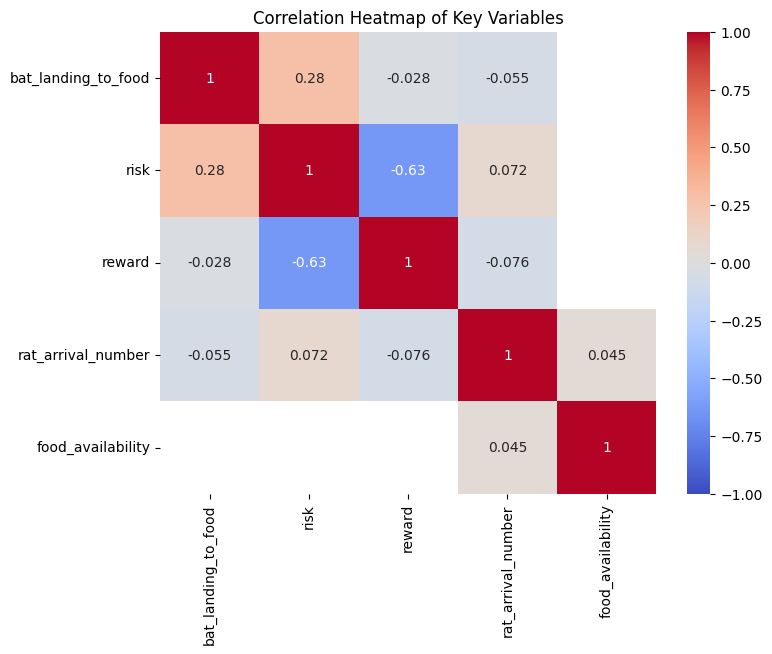

In [28]:
# Correlation Heatmap
plt.figure(figsize=(8, 6))
corr = merged_df[['bat_landing_to_food', 'risk', 'reward', 'rat_arrival_number', 'food_availability']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Key Variables')
plt.show()

# Regression for Vigilance

In [30]:
import statsmodels.api as sm
# Fill NaN values in 'rat_minutes' with 0
merged_df['rat_minutes'] = merged_df['rat_minutes'].fillna(0)
X = sm.add_constant(merged_df[['rat_minutes', 'risk', 'hours_after_sunset']])
y = merged_df['bat_landing_to_food']
model = sm.OLS(y, X).fit()
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     bat_landing_to_food   R-squared:                       0.081
Model:                             OLS   Adj. R-squared:                  0.078
Method:                  Least Squares   F-statistic:                     27.00
Date:                 Thu, 16 Oct 2025   Prob (F-statistic):           9.62e-17
Time:                         03:02:55   Log-Likelihood:                -3506.1
No. Observations:                  925   AIC:                             7020.
Df Residuals:                      921   BIC:                             7040.
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  5.7

# ML: Logistic for Risk Prediction

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
features = merged_df[['food_availability', 'rat_arrival_number', 'hours_after_sunset']].copy()
target = merged_df['risk']
# Fill NaN values in 'food_availability' with 0
features['food_availability'] = features['food_availability'].fillna(0)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Coefficients:", clf.coef_)

Accuracy: 0.5359712230215827
Coefficients: [[ 1.31715321  0.10404507 -0.04389577]]


# Visual: Scatter for Vigilance vs Rat Minutes

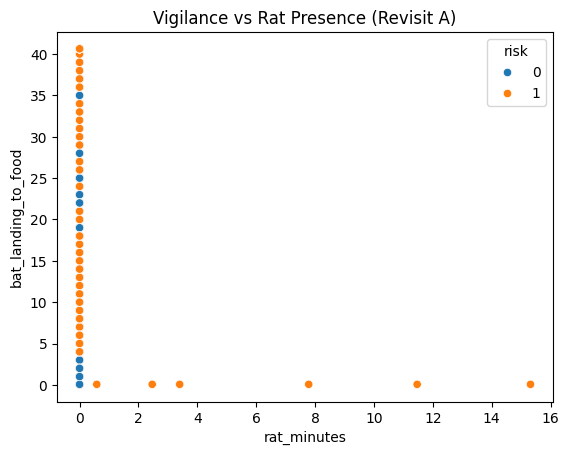

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(x='rat_minutes', y='bat_landing_to_food', hue='risk', data=merged_df)
plt.title('Vigilance vs Rat Presence (Revisit A)')
plt.show()

# Table: Summary Stats by Risk

In [36]:
print(merged_df.groupby('risk').mean(numeric_only=True))

      bat_landing_to_food  seconds_after_rat_arrival    reward     month  \
risk                                                                       
0                5.441325                 277.598253  0.842795  3.794760   
1               11.614513                 291.342612  0.209850  3.813704   

      hours_after_sunset    season  hours_after_sunset_outlier_bat  \
risk                                                                 
0               5.673617  0.855895                        0.017467   
1               5.453962  0.817987                        0.008565   

      month_inferred_bat  sec_from_ratstart_calc  sec_mismatch  \
risk                                                             
0               4.109170              277.074236     -0.524017   
1               4.173448              295.503212      4.160600   

      bat_landing_number  food_availability  rat_minutes  rat_arrival_number  \
risk                                                                 